# Kaggle - Store Sales Competition

## Introduction:

The code in this notebook was created to participate in the `Store Sales - Time Series Forecasting` competition on `kaggle.com` (https://www.kaggle.com/competitions/store-sales-time-series-forecasting). The competition's goal is to **use time series forecasting methods** to forecast store sales on data from a grocery retailer.

To complete the task, my current knowledge on Time Series Analysis as well as the input from the **Time Series course** available on kaggle (https://www.kaggle.com/learn/time-series) were used. The course content was very useful as it provided several functions for working with time series data. Some of these functions are implemented in this notebook. 

## Import modules:

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from scipy.signal import periodogram

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [6]:
from joblib import Parallel, delayed
import warnings

## Define useful functions (from Time Series Course on Kaggle)

In [7]:
def seasonal_plot(X, y, period, freq, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    
    # Colors palette:
    palette = sns.color_palette("husl", n_colors = X[period].nunique())
    
    # Plot
    ax = sns.lineplot(x = freq, y = y, hue = period, data = X, ci = False, ax = ax, palette = palette, legend = False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    return ax

In [8]:
def plot_periodogram(series, detrend = 'linear', title = "Periodogram", ax = None):
    from scipy.signal import periodogram
    
    fs = pd.Timedelta(np.timedelta64(1, "Y")) / pd.Timedelta(1, "D")
    freqencies, spectrum = periodogram(series, fs = fs, detrend = detrend, window = "boxcar", scaling = 'spectrum')
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.step(freqencies, spectrum, color = "green")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)",
                        "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation = 30)
    ax.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(title)
    
    return ax

## Import datasets:

The competition offers several datasets:

1. Training & test dataset
2. Oil price data
3. Data on holiday events
4. Transaction data
5. Store data 

### Training and test datasets:

In [9]:
dtypes = {'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint64'}

In [10]:
train_data = pd.read_csv("train.csv", dtype = dtypes, parse_dates = ['date'], infer_datetime_format = True)

In [11]:
test_data = pd.read_csv("test.csv", dtype = dtypes, parse_dates = ['date'], infer_datetime_format = True)

Make some quick inspections:

In [12]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


As shown above, the dataset contains time series data with daily observations. Therefore, an appropriate index is required: set the date column as index.

In [14]:
train_data = train_data.set_index("date").to_period("D")

In [15]:
test_data = test_data.set_index("date").to_period("D")

### Oil price data:

In [16]:
oildata = pd.read_csv("oil.csv", parse_dates = ["date"], infer_datetime_format = True)

In [17]:
oildata.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Daily price data. Again, the date column is set as index. Moreover, column names are changed for convenience:

In [18]:
oildata = oildata.set_index("date").to_period("D")

In [19]:
oildata.rename(columns = {"dcoilwtico": "oil_price"}, inplace = True)

### Holiday events:

In [20]:
dtypes_holiday = {'type': 'category', 'locale': 'category', 'locale_name': 'category', 'description': 'category',
                  'transferred': 'bool'}

In [21]:
holidays_events = pd.read_csv("../Kaggle_Store_Sales_Time_Series/holidays_events.csv",
                              dtype = dtypes_holiday, parse_dates = ['date'], infer_datetime_format = True)

In [22]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Time series data on holiday events in Ecuador. Set date column as index:

In [23]:
holidays_events = holidays_events.set_index("date").to_period("D")

### Transactions:

In [24]:
dtypes = {'store_nbr': 'category', 'transactions': 'int64'}

In [25]:
transactions = pd.read_csv("transactions.csv", dtype = dtypes, parse_dates = ["date"], infer_datetime_format = True)

In [26]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Time series data on transactions by date and store number. Again: set date column as index.

In [27]:
transactions = transactions.set_index("date").to_period("D")

### Store data:

In [28]:
store_data = pd.read_csv("stores.csv")

In [29]:
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


According to the `kaggle.com` competition webpage (see link in the introduction):

* Store metadata, including city, state, type, and cluster.
* Cluster is a grouping of similar stores.

## Exploratory Data Analysis

### Training dataset 

In [30]:
train_data.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

Variables/ features:

* sales: sales volume. Feature to predict/ forecast.
* id: unique identifier (will be dropped as it does not contain any information).
* store_nbr: number that identifies the store at which the products are sold.
* family: identifies the type of product sold.
* onpromotion: total number of items in a product family that were being promoted at a store at a given date.

In [31]:
train_data.drop(columns = ["id"], axis = 1, inplace = True)

#### Store (number)

In [32]:
print(f'Number of different stores: {train_data["store_nbr"].nunique()}')

Number of different stores: 54


Do sales differ by store? 

In [33]:
store_sales = train_data.groupby("store_nbr").mean()["sales"].sort_values()

In [34]:
# fig, ax = plt.subplots(figsize = (16, 16))
# store_sales.plot(kind = "barh", ax = ax)
# plt.show()

**Findings**: 

* There seems to be a lot of variation in sales when comparing the stores.

### (Product) Family

In [35]:
print(f'Number of product families: {train_data["family"].nunique()}')

Number of product families: 33


Similar to the question above: do sales differ by product family?

In [36]:
sales_family = train_data.groupby("family").mean()["sales"].sort_values()

In [37]:
# fig, ax = plt.subplots(figsize = (16, 16))
# sales_family.plot(kind = "barh", ax = ax)
# plt.show()

**Findings**: 

* A lot of product families show zero/ low sale figures.
* Moreover, a few families account for a large fraction of all sales (see also table below).

In [38]:
sales_family_pct = train_data.groupby("family").sum()["sales"].sort_values(ascending = False) / train_data["sales"].sum()

In [39]:
sales_family_pct.cumsum()[0:6]

family
GROCERY I       0.319903
BEVERAGES       0.521976
PRODUCE         0.636264
CLEANING        0.727096
DAIRY           0.787160
BREAD/BAKERY    0.826404
Name: sales, dtype: float32

As indicated by the table, five product families make up appr. 80 percent of all sales. 

### Onpromotion

In [40]:
train_data["onpromotion"].describe()[1:]

mean      2.602770
std      12.218882
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max     741.000000
Name: onpromotion, dtype: float64

Does the promotion correlate with sales?

In [41]:
train_data.corr(method = "pearson").loc["sales", "onpromotion"]

0.4279232048895993

**Findings**:

* As indicated above, sales and promotions seem to be correlated to some extent. Hence, one could add promotions to forecast sales.

### Oil data:

As the dataset contains time series data on oil prices, a visualization could provide first useful insights:

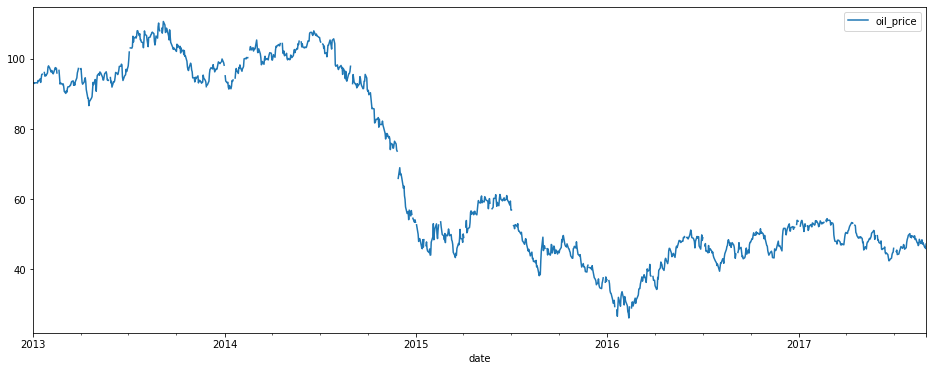

In [42]:
fig, ax = plt.subplots(figsize = (16, 6))
oildata.plot(kind = "line", ax = ax)
plt.show()

The gaps in the time series indicate missing values.

In [43]:
oildata.isna().sum()

oil_price    43
dtype: int64

To impute the missing values, (linear) interpolation is used. Linear interpolation replaces missing values with linearly-spaced values between the two nearest defined data points.

In [44]:
oildata['oil_price_interpolated'] = oildata["oil_price"].interpolate()

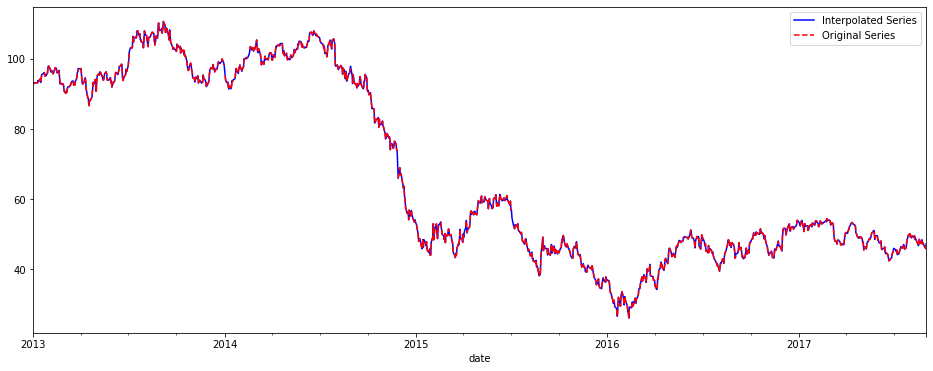

In [45]:
fig, ax = plt.subplots(figsize = (16, 6))
oildata["oil_price_interpolated"].plot(kind = "line", style = "b-", ax = ax, label = "Interpolated Series")
oildata["oil_price"].plot(kind = "line", style = "r--", ax = ax, label = "Original Series")
ax.legend()
plt.show()

After the interpolation all gaps filled. Next, the correlation between oil prices and sales is examined.

In [46]:
sales_daily = pd.DataFrame(train_data.groupby("date").sum(), columns = ["sales"])

In [47]:
sales_oil = sales_daily.join(oildata["oil_price_interpolated"])

In [48]:
sales_oil.corr().loc["sales", "oil_price_interpolated"]

-0.6904566107969352

**Findings**:

* The coefficient suggests a strong negative correlation. Hence, it could be beneficial to include oil price data to our analysis.

### Holiday Events

In [49]:
holidays_events.columns

Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

Variables/ Features:

* type: type of day, e.g. holiday or transferred holiday
* Information regarding these types on `kaggle.com` webpage:
    * pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12.
    * Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
* locale: defines whether the event is national, regional or local
* locale_name: name of location, e.g. 'Ecuador if national holiday.
* description: name of event.
* transferred: states whether the event was transferred.

Example of transferred events:

In [50]:
holidays_events[holidays_events["description"] == "Independencia de Guayaquil"]

,type,locale,locale_name,description,transferred
date,,,,,
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False


In [51]:
holidays_events.loc["2012-10-12"]

type                                      Transfer
locale                                    National
locale_name                                Ecuador
description    Traslado Independencia de Guayaquil
transferred                                  False
Name: 2012-10-12, dtype: object

In [52]:
holidays_events[holidays_events.transferred == True]["transferred"].count()

12

All transferred holiday events are dropped as they were celebrated on a different dates:

In [53]:
holidays_events.drop(index = holidays_events[holidays_events.transferred == True].index, inplace = True)

Moreover, all "Work Day" type dates are dropped as they do not constitute holiday events:

In [54]:
holidays_events.drop(index = holidays_events[holidays_events.type == "Work Day"].index, inplace = True)

In [55]:
holidays_events.type.value_counts()

Holiday       208
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        0
Name: type, dtype: int64

### Transaction data:

Firstly, transaction volume by store are examined:

In [56]:
store_transactions = transactions.groupby("store_nbr").mean()["transactions"].sort_values()

In [57]:
# fig, ax = plt.subplots(figsize = (16, 16))
# store_transactions.plot(kind = "barh", ax = ax)
# plt.show()

**Findings**:

* Similar to sales (obviously). Large variation in transaction volume. Next, I do look at the correlation between sales.

In [58]:
store_sales_sum = pd.DataFrame(train_data.groupby(["date", "store_nbr"]).sum(), columns = ["sales"])

In [59]:
transactions_ = transactions.set_index("store_nbr", append = True)

In [60]:
sales_transactions = store_sales_sum.join(transactions_)

In [61]:
sales_transactions["transactions"] = sales_transactions["transactions"].fillna(0)

In [62]:
sales_transactions.corr(method = "spearman").loc["sales", "transactions"]

0.8545640063181913

**Findings**:

* The high correlation meets my expectations. Therefore, it could be beneficial to include transactions data to our models.

### Sales

In [63]:
train_data["sales"].describe()["count"]

3000888.0

The dataset contains a lot of data points (appr. 3 mio.) since sales for over 50 stores were recorded. In order to facilitate the analysis, average sales per day are analysed.

In [64]:
average_sales = pd.DataFrame(train_data["sales"].groupby("date").mean(), columns = ["sales"]) 

In [65]:
average_sales.index = average_sales.index.to_timestamp()

I do start with a simple time series plot to obtain first insights:

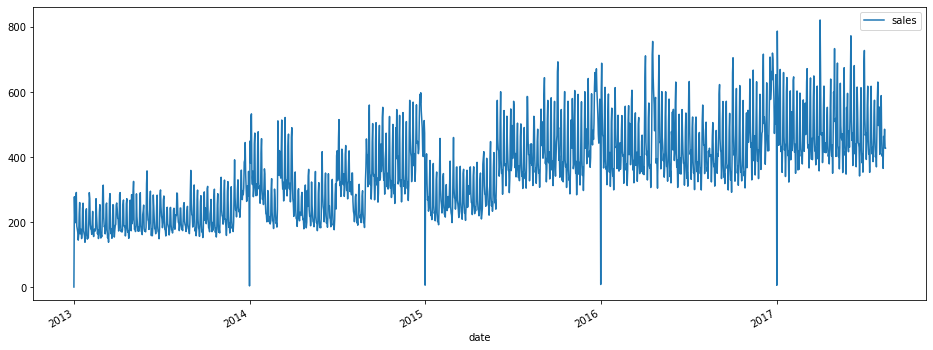

In [66]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales.plot(kind = "line", ax = ax)
plt.show()

Second, the year 2017 is examined in detail because the goal is to forecast sales in 2017:

In [67]:
average_sales_2017 = average_sales.loc["2017"]

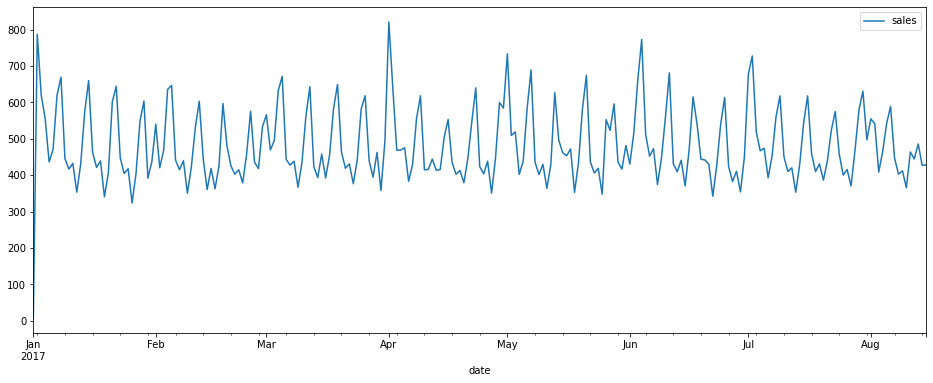

In [68]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017.plot(kind = "line", ax = ax)
plt.show()

**Findings**:

1. There seems to be a slowly increasing trend in the data for the whole period. Contrarily, the plot of 2017 data does not suggest the existence of a trend.
2. Additionally, both plots suggest that the data exhibits seasonality.
3. Moreover, at the beginning of each year a huge drop in sales appears (observable in the first plot).

What causes the drop at the beginning of the year?

In [69]:
average_sales.loc[(average_sales.index.dayofyear == 1) | (average_sales.index.dayofyear == 365) \
                  | (average_sales.index.dayofyear == 366)]

,sales
date,
2013-01-01,1.409438
2013-12-31,284.660309
2014-01-01,4.827197
2014-12-31,473.838654
2015-01-01,7.168135
2015-12-31,541.325195
2016-01-01,9.221882
2016-12-30,652.998352
2016-12-31,622.341675


**Findings**:

* As indicated above, the huge drop in sales is related to the first day of the year which is commonly accompanied by closed stores (well duh).

## Time Series Decomposition

Since the time series data could include a  trend as well as a seasonal component, the time series is decomposed to examine the preliminary findings.

In [70]:
# multi_decomp = seasonal_decompose(average_sales["sales"], model = "multiplicative", period = 365)

In [71]:
additive_decomp = seasonal_decompose(average_sales["sales"], model = "additive", period = 365)

In [72]:
#plt.rcParams.update({'figure.figsize': (16, 10)})
#multi_decomp.plot()
#plt.show()

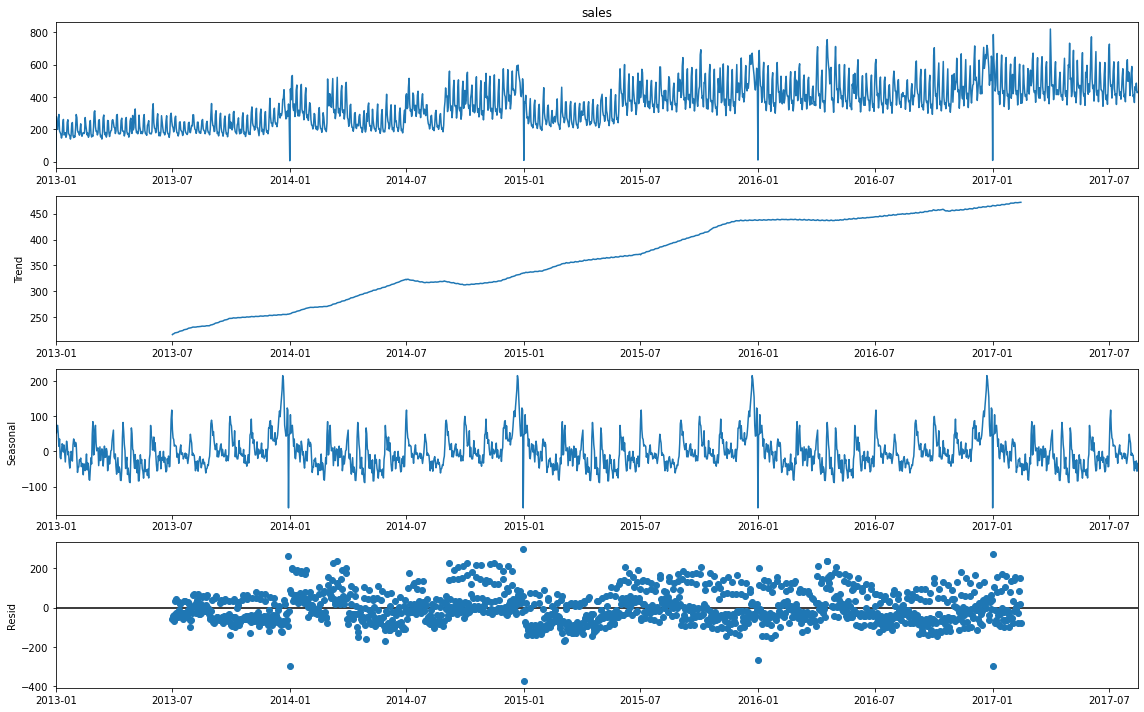

In [73]:
plt.rcParams.update({'figure.figsize': (16, 10)})
additive_decomp.plot()
plt.show()

**Findings**:

* As stated above, a trend as well as seasonal component are clearly observable.
* I will continue with an additive model as the magnitude of the seasonal components does not change over time. Moreover, the model's residuals look random which is preferable.

### Trend Component

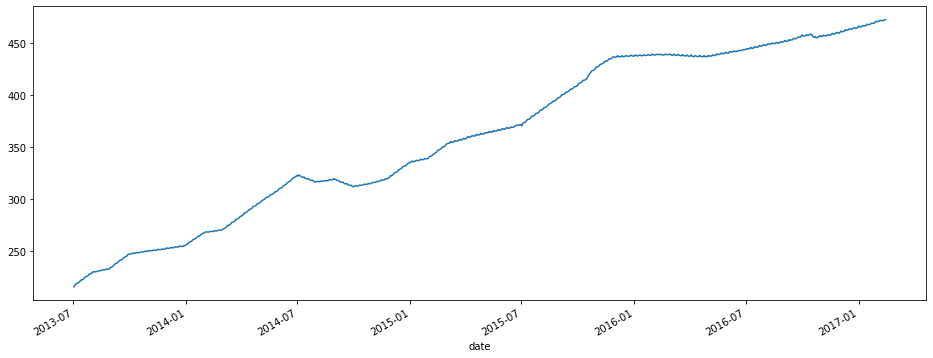

In [74]:
plt.rcParams.update({'figure.figsize': (16, 6)})
additive_decomp.trend.plot()
plt.show()

As presumed, the complete time series exhibits an increasing trend. For 2017 a moving average "filter" is applied to the data to analyse whether it has a trend component, too.

In [75]:
average_sales_2017_mvgavg = average_sales_2017.rolling(window = 30, center = True).mean()

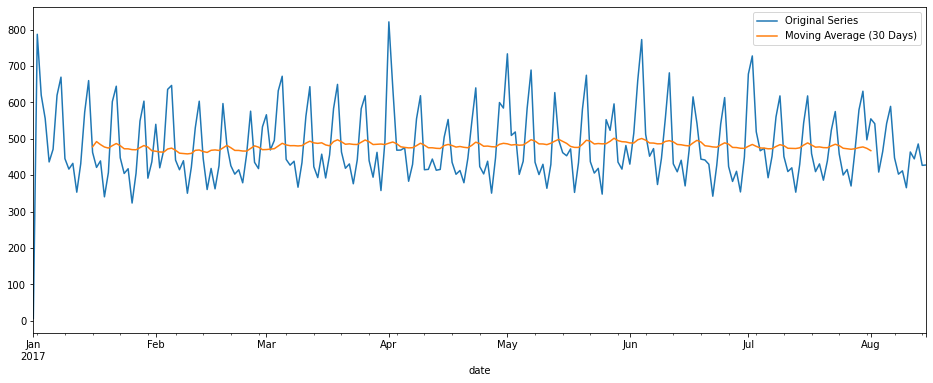

In [76]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017.plot(kind = "line", ax = ax)
average_sales_2017_mvgavg.plot(kind = "line", ax = ax)
ax.legend(["Original Series", "Moving Average (30 Days)"])
plt.show()

The plotted data for 2017 finally confirms that there is no increasing/decreasing trend. Following, a linear regression is utilized to model the horizontal "trend":

In [77]:
det_process_trend = DeterministicProcess(index = average_sales_2017.index, constant = True, order = 1)
X_trend = det_process_trend.in_sample()

In [78]:
lin_model_trend = LinearRegression(fit_intercept = False).fit(X_trend, average_sales_2017["sales"])

In [79]:
trend_pred = pd.Series(lin_model_trend.predict(X_trend), index = X_trend.index)

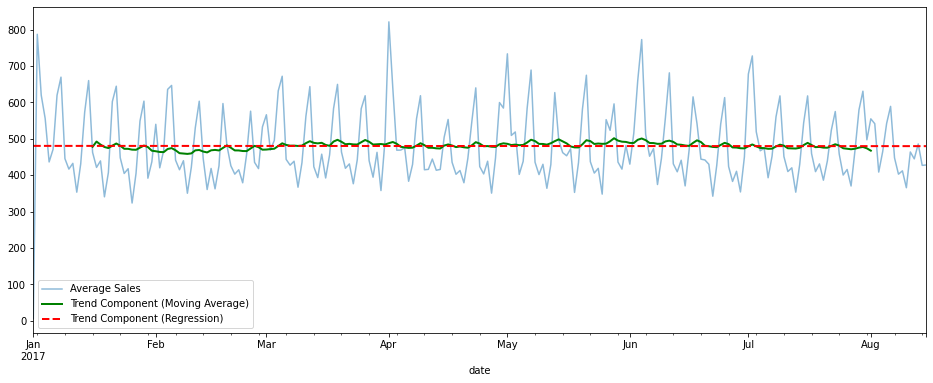

In [80]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017["sales"].plot(kind = "line", alpha = 0.5, ax = ax)
average_sales_2017_mvgavg.plot(kind = "line", linewidth = 2, color = "green", ax = ax)
trend_pred.plot(kind = "line", linewidth = 2, color = "red", style = "--", ax = ax,)
ax.legend(["Average Sales", "Trend Component (Moving Average)", "Trend Component (Regression)"])
plt.show()

### Seasonal Component

As suggested above, the complete dataset exhibits seasonality. This is also shown by the decomposition model:

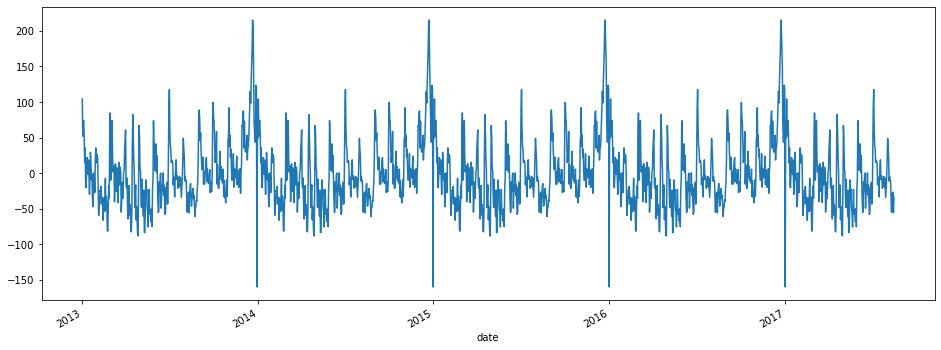

In [81]:
plt.rcParams.update({'figure.figsize': (16, 6)})
additive_decomp.seasonal.plot()
plt.show()

The plot suggests the existence of seasonality as increasing sales at the end of each year are observable. Next, data for 2017 is examined separately:

In [82]:
average_sales_2017_detrended = average_sales_2017["sales"] - trend_pred

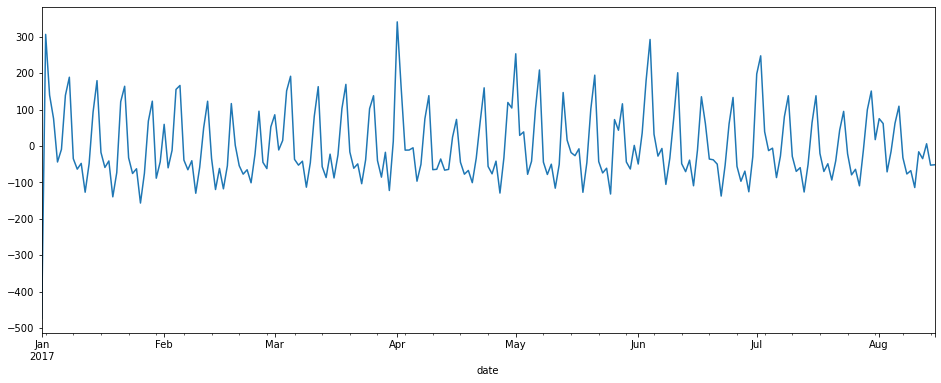

In [83]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017_detrended.plot(kind = "line", ax = ax)
plt.show()

The data for 2017 shows seasonality as well. In the following, the seasonal patterns are examined year by year.

In [84]:
average_sales_2013 = train_data["sales"].groupby("date").mean().loc["2013"]
average_sales_2014 = train_data["sales"].groupby("date").mean().loc["2014"]
average_sales_2015 = train_data["sales"].groupby("date").mean().loc["2015"]
average_sales_2016 = train_data["sales"].groupby("date").mean().loc["2016"]
average_sales_2017 = train_data["sales"].groupby("date").mean().loc["2017"]

In [85]:
X_season_2013 = average_sales_2013.to_frame()
X_season_2014 = average_sales_2014.to_frame()
X_season_2015 = average_sales_2015.to_frame()
X_season_2016 = average_sales_2016.to_frame()
X_season_2017 = average_sales_2017.to_frame()

In [86]:
seasonal_dfs = [X_season_2013, X_season_2014, X_season_2015, X_season_2016, X_season_2017]

In [87]:
for df in seasonal_dfs:
    df["month"] = df.index.month
    df["week"] = df.index.week
    df["day"] = df.index.dayofweek

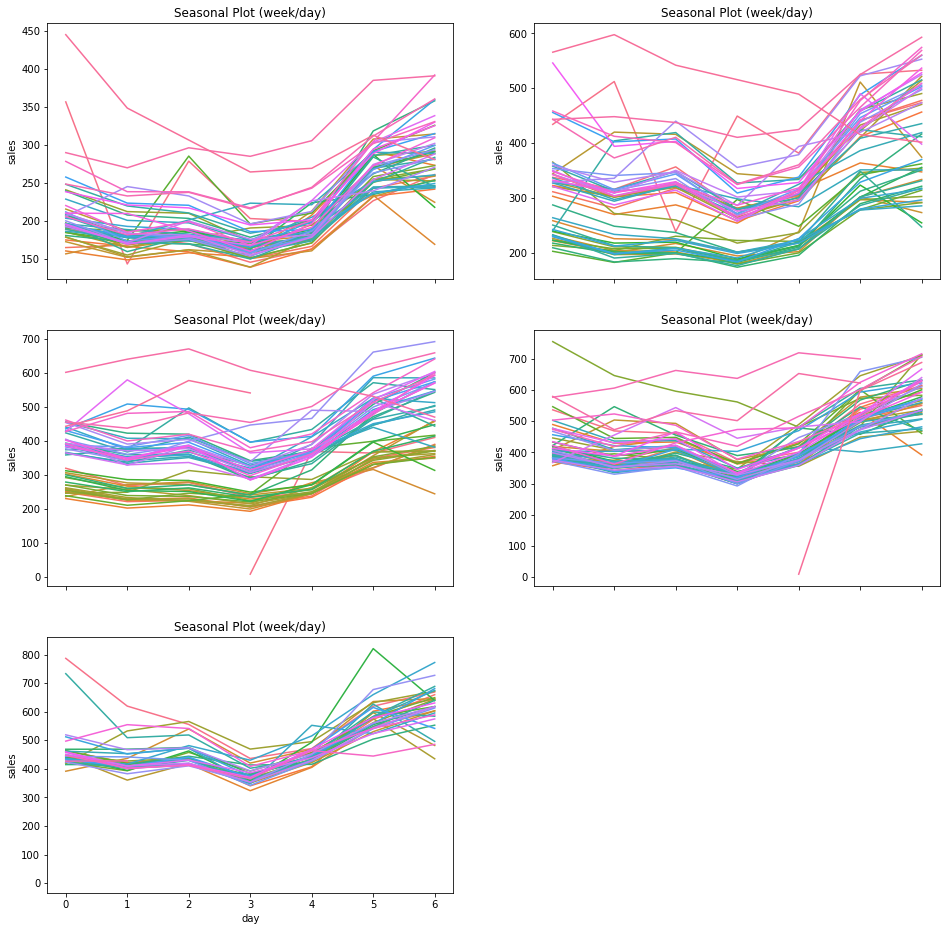

In [88]:
fig, axes = plt.subplots(3, 2, figsize = (16, 16), sharex = True)
seasonal_plot(X_season_2013, y = "sales", period = "week", freq = "day", ax = axes[0, 0])
seasonal_plot(X_season_2014, y = "sales", period = "week", freq = "day", ax = axes[0, 1])
seasonal_plot(X_season_2015, y = "sales", period = "week", freq = "day", ax = axes[1, 0])
seasonal_plot(X_season_2016, y = "sales", period = "week", freq = "day", ax = axes[1, 1])
seasonal_plot(X_season_2017, y = "sales", period = "week", freq = "day", ax = axes[2, 0])
axes[2, 1].axis("off")
plt.show()

The seasonal plots show:

1. that sales tend to be higher on weekend days (higher on the right hand side of the plots) and
2. they suggest the existence of weekly seasonality (since the lines are not stacked on each other, some are higher or lower).

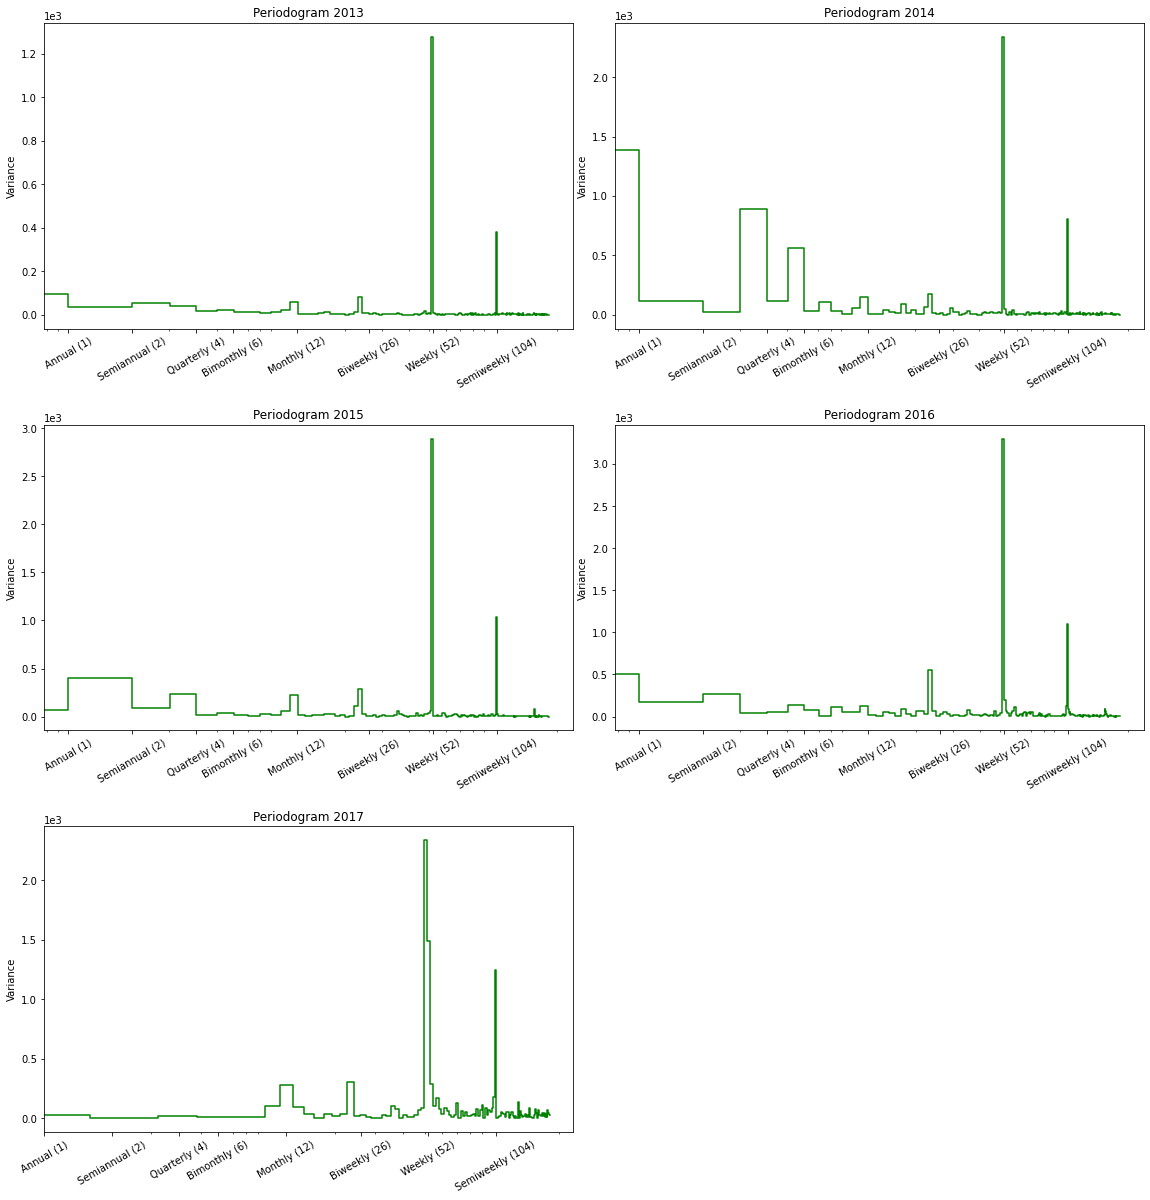

In [89]:
fig, axes = plt.subplots(3, 2, figsize = (16, 16))
fig.tight_layout(h_pad = 7.5)
plot_periodogram(average_sales_2013, title = "Periodogram 2013", ax = axes[0, 0])
plot_periodogram(average_sales_2014, title = "Periodogram 2014", ax = axes[0, 1])
plot_periodogram(average_sales_2015, title = "Periodogram 2015", ax = axes[1, 0])
plot_periodogram(average_sales_2016, title = "Periodogram 2016", ax = axes[1, 1])
plot_periodogram(average_sales_2017, title = "Periodogram 2017", ax = axes[2, 0])
axes[2, 1].axis("off")
plt.show()

**Findings**:
* As presumed, the average sales series suggests strong weekly seasonality.
* Additionally, a strong monthly, semiweekly and biweekly seasonality can be observed in all periodograms.

In the following, I will concentrate on the 2017 data again:

* The weekly seasonality will be captured by **time-step features**.
* All other seasonalities will be modelled via **Fourier features**. From the kaggle course on Time Series: Fourier features are pairs of sine and cosine curves. In Time Series Analysis one such feature is implemented **for each potential frequency** in the season **starting with the longest**).
* To model the remaining seasonalities of the 2017 dataset **three** Fourier features are required:

    * One for the highest frequency (the monthly one as it consitutes the first peak; looking from the left).
    * A second one for the lowest frequency, which is the small peak located between the biweekly and weekly peaks. It is assumed to be the lowest frequency because the periogram falls off in this area (the following peaks are either captured with time-step features or ignored). 
    * The last one is for the peak (appr. at the biweekly label) between the highest and lowest frequency.
    * That sums up to 3 pairs of sine-cosine pairs (one pair for each peak: monthly, biweekly and the small one after biweekly).

Some further information regarding the choice of features:
* https://www.kaggle.com/learn/time-series/discussion/303462


In [90]:
fourier = CalendarFourier(freq = "M", order = 3)

In [91]:
det_process_season = DeterministicProcess(index = average_sales_2017.index, constant = True, order = 1,
                                  seasonal = True, period = 7, additional_terms = [fourier], drop = True)

The features are used as input for a linear regression to model the seasonality:

In [92]:
X_season = det_process_season.in_sample()

In [93]:
lin_model_season = LinearRegression(fit_intercept = False).fit(X_season, average_sales_2017)

In [94]:
season_pred = pd.Series(lin_model_season.predict(X_season), index = X_season.index)

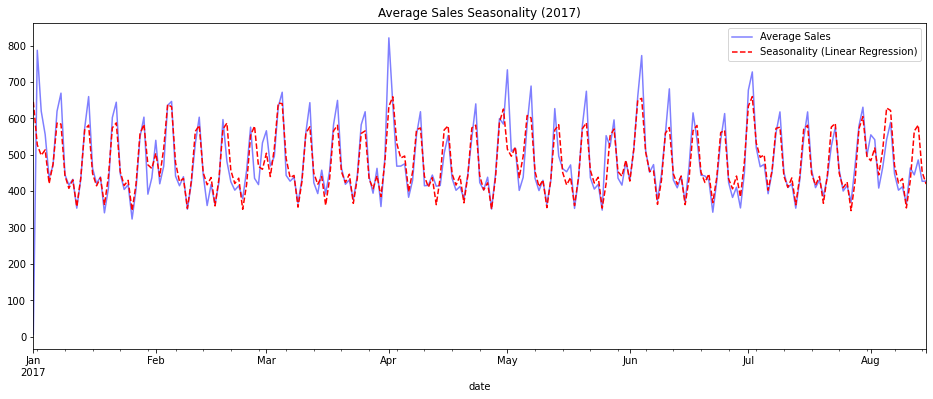

In [95]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017.plot(kind = "line", color = "blue", alpha = 0.5, title = "Average Sales Seasonality (2017)",
                        ax = ax)
season_pred.plot(kind = "line", color = "red", style = "--")
ax.legend(["Average Sales", "Seasonality (Linear Regression)"])
plt.show()

In [96]:
print(f'Mean Squared Error: {mean_squared_error(average_sales_2017, season_pred)}')
print(f'Mean Squared Log Error: {mean_squared_log_error(average_sales_2017, season_pred)}')

Mean Squared Error: 3828.8162565306425
Mean Squared Log Error: 0.09264558641171178


The plot suggests that the seasonal pattern was modelled properly. (The evaluation metrics are for a comparison that will follow below.) Next, the series is deseasonalized:

In [97]:
average_sales_2017_deseason = average_sales_2017 - season_pred

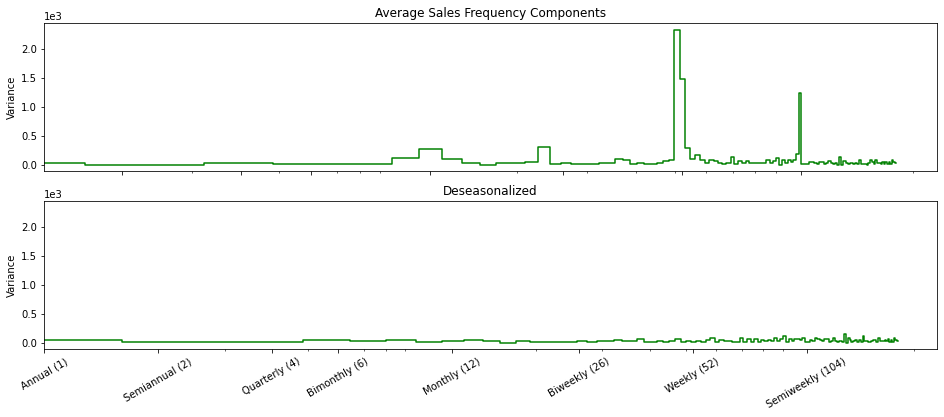

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (16, 6))
ax1 = plot_periodogram(average_sales_2017, ax = ax1)
ax1.set_title("Average Sales Frequency Components")
ax2 = plot_periodogram(average_sales_2017_deseason, ax = ax2);
ax2.set_title("Deseasonalized")
plt.show()

The lower periodogram suggests that after accounting for all seasonalities there is not much of a seasonal component left in the time series. In the following, holiday events are added to the analysis.

### Seasonality with holiday events:

To add further insights to the seasonality analysis, national as well as regional holidays are taken into consideration:

In [99]:
holidays_2017 = (holidays_events.query("locale in ['National', 'Regional']").loc['2017', ['description']]
                 .assign(description = lambda x: x.description.cat.remove_unused_categories()))

Drop the dates that are not in included in the training data:

In [100]:
for holidate in holidays_2017.index:
    if holidate not in average_sales_2017:
        holidays_2017.drop(labels = [holidate], axis = 0, inplace = True)

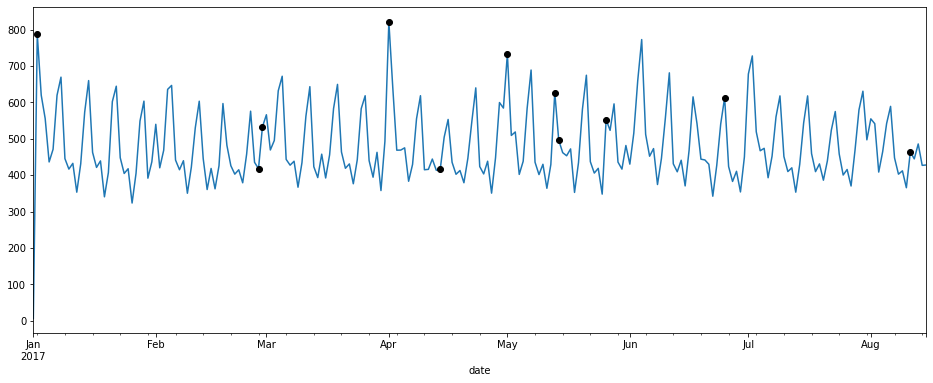

In [101]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017.plot(ax = ax)
plt.plot_date(holidays_2017.index, average_sales_2017[holidays_2017.index], color = "black")
plt.show()

Some of the holidays seem to correlate with the series as a considerable amount of black dots sit on the spikes. Next: create dummy variables for all holidays and keep just one for each date:

In [102]:
holidays_2017_dummies = pd.get_dummies(holidays_2017)
holidays_2017_dummies = holidays_2017_dummies.groupby(level = 0).first()

Combine dummy dataframe with the features dataframe:

In [103]:
X_with_holidays = X_season.join(holidays_2017_dummies, how = "left", on = "date").fillna(0.0)

Fit a linear model to the data and make predictions:

In [104]:
lin_model_holidays = LinearRegression(fit_intercept = False).fit(X_with_holidays, average_sales_2017)

In [105]:
season_holidays_pred = pd.Series(lin_model_holidays.predict(X_with_holidays), index = X_with_holidays.index)

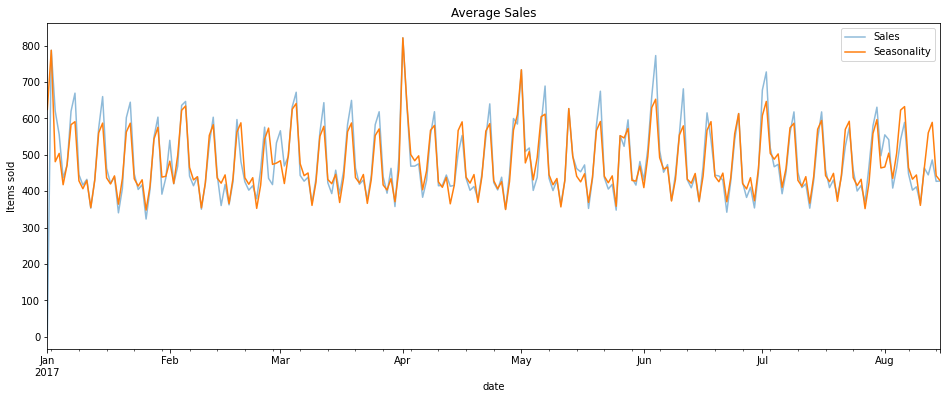

In [106]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017.plot(kind = "line", alpha = 0.5, title = "Average Sales", ylabel = "Items sold",
                  label = "Sales", ax = ax)
season_holidays_pred.plot(kind = "line", label = "Seasonality", ax = ax)
ax.legend()
plt.show()

In [107]:
print(f'Mean Squared Error: {mean_squared_error(average_sales_2017, season_holidays_pred)}')
print(f'Mean Squared Log Error: {mean_squared_log_error(average_sales_2017, season_holidays_pred)}')

Mean Squared Error: 2916.9586653158362
Mean Squared Log Error: 0.08925546164126448


It seems that including holidays improves our model of seasonality. (Compare the evaluation metrics to the metrics calculated before.)

### Random component

Lastly, the remaining (random) component is examined:

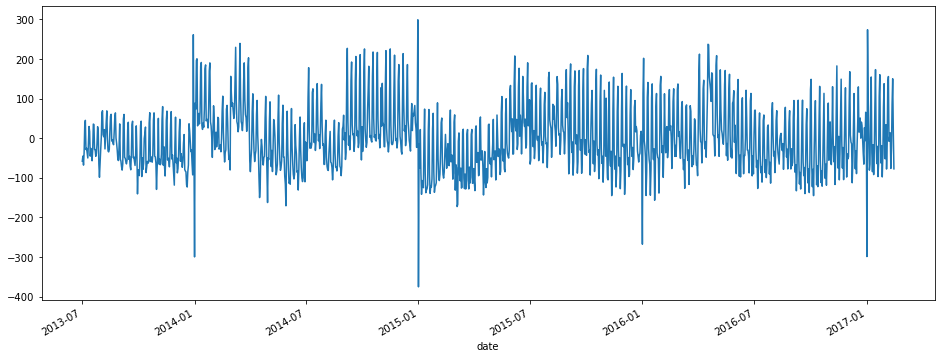

In [108]:
plt.rcParams.update({'figure.figsize': (16, 6)})
additive_decomp.resid.plot()
plt.show()

For 2017 only:

In [109]:
average_sales_2017_resid = average_sales_2017 - trend_pred.to_period(freq = "D") - season_holidays_pred

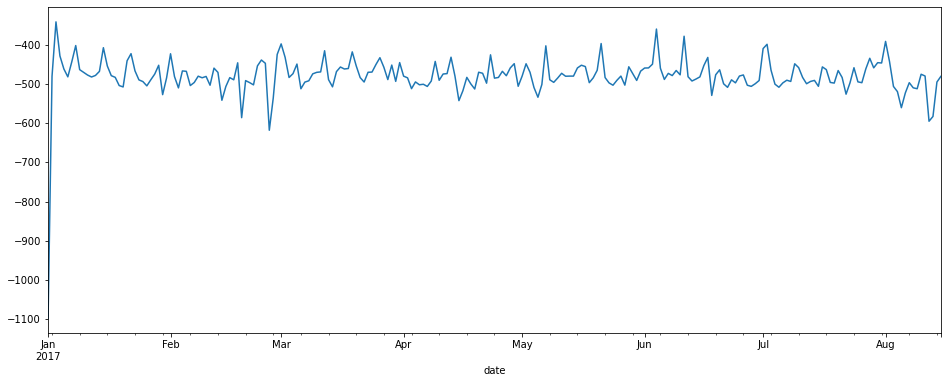

In [110]:
fig, ax = plt.subplots(figsize = (16, 6))
average_sales_2017_resid.plot()
plt.show()

Based on the plot above, one might argue that the remainder does not exhibit any observable pattern. To add further evidence, autocorrelation as well as partial autocorreation functions are plotted:

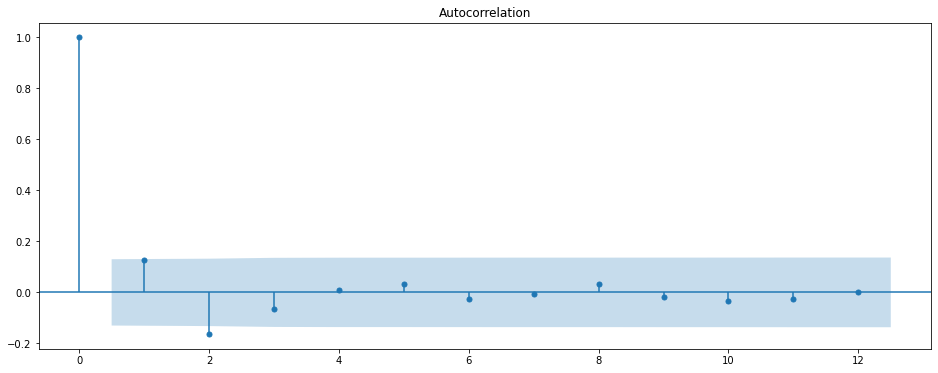

In [111]:
fig, ax = plt.subplots(figsize = (16, 6))
plot_acf(average_sales_2017_resid, lags = 12, ax = ax)
plt.show()

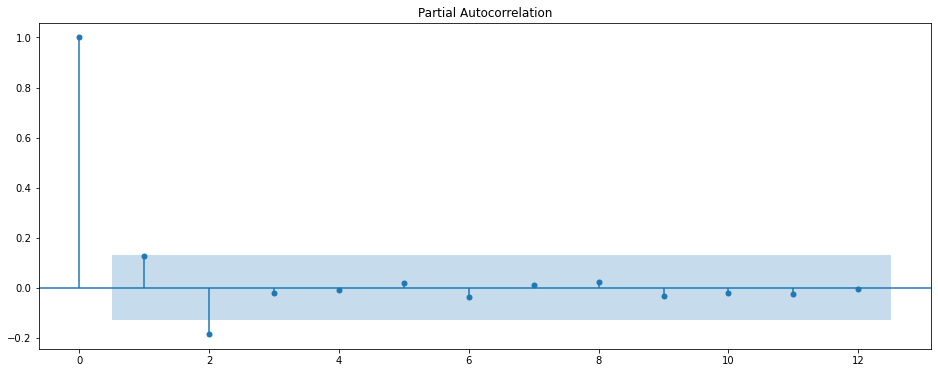

In [112]:
fig, ax = plt.subplots(figsize = (16, 6))
plot_pacf(average_sales_2017_resid, lags = 12, ax = ax)
plt.show()

**Findings**:

* Most of lags are insignificant. Hence, one could argue that the residual component follows a random process.

## Final Model:

How does the example submission does look like?

In [113]:
sample_sub = pd.read_csv("sample_submission.csv")

In [114]:
# sample_sub

Each row holds a forecasted sales value of a product family in one specific store. 

### Prepare data:

In [115]:
y_regression = train_data.set_index(["store_nbr", "family"], append = True).sort_index()
y_regression.drop(columns = ['onpromotion'], axis = 1, inplace = True)

In [116]:
y_regression = y_regression.unstack(['store_nbr', 'family']).loc["2017"]

Next, the following features are created:

1. 3 Fourier features for seasonal patterns
2. Day of the week dummies for additional weekly seasonality
3. Holiday events for seasonality as well
4. Polynomial elements of order 1 (linear) for trend component
5. Additional dummy for the First Day of the New Year
6. Interpolated oil price data

In [117]:
fourier_regression = CalendarFourier(freq = "M", order = 3)

In [118]:
det_process_regression = DeterministicProcess(index = y_regression.index, constant = True, order = 1, seasonal = True,
                                         period = 7, additional_terms = [fourier_regression], drop = True)

In [119]:
X_regression_train = det_process_regression.in_sample()

In [120]:
X_regression_train = X_regression_train.join(holidays_2017_dummies, how = "left", on = "date").fillna(0.0)

In [121]:
X_regression_train["new_year"] = (X_regression_train.index.dayofyear == 1)
X_regression_train["new_year"] = X_regression_train.apply(lambda x: 1.0 if x["new_year"] == True else 0.0, axis = 1)

In [122]:
X_regression_train = X_regression_train.join(oildata["oil_price_interpolated"], how = "left", on = "date").fillna(0.0)

### Fit model and make predictions

In [123]:
regression_model = LinearRegression(fit_intercept = False).fit(X_regression_train, y_regression)

In [124]:
regression_model_pred = pd.DataFrame(regression_model.predict(X_regression_train), index = X_regression_train.index,
                                     columns = y_regression.columns)

In [125]:
# regression_model_pred

### Evaluation:

In [126]:
regression_model_pred_ = regression_model_pred.stack(['store_nbr', 'family']).copy()
y_regression_ = y_regression.stack(['store_nbr', 'family']).copy()

Prediction of sales should be greater or equal to 0:

In [127]:
y_regression_['sales_pred'] = regression_model_pred_['sales'].clip(0.0)

In [128]:
y_regression_.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'],
                                                                       x['sales_pred'])).sort_values(ascending = False)

family
SCHOOL AND OFFICE SUPPLIES    1.646676
LIQUOR,WINE,BEER              0.666202
LINGERIE                      0.380750
GROCERY II                    0.369782
GROCERY I                     0.319856
HOME AND KITCHEN I            0.319613
BEVERAGES                     0.301214
PRODUCE                       0.294090
CELEBRATION                   0.286852
LAWN AND GARDEN               0.274066
CLEANING                      0.274050
HARDWARE                      0.259508
BEAUTY                        0.254216
AUTOMOTIVE                    0.246395
SEAFOOD                       0.236767
MAGAZINES                     0.236706
LADIESWEAR                    0.230250
HOME AND KITCHEN II           0.226900
PLAYERS AND ELECTRONICS       0.217950
PET SUPPLIES                  0.204261
FROZEN FOODS                  0.197175
DAIRY                         0.193450
BREAD/BAKERY                  0.174811
EGGS                          0.162214
PERSONAL CARE                 0.158896
MEATS             

**Findings**:

* Most of the MSLE are below 1.0
* Thee product family 'SCHOOL AND OFFICE SUPPLIES', however, is an exception. Lets investigate the results:

In [129]:
prod_fam_sos = "SCHOOL AND OFFICE SUPPLIES"

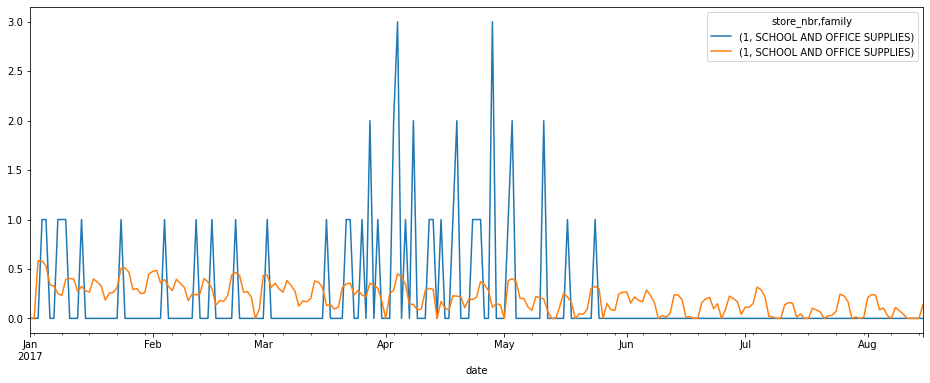

In [130]:
fig, ax = plt.subplots(figsize = (16, 6))
y_regression_.unstack(['store_nbr', 'family']).loc(axis = 1)[:, "1", prod_fam_sos]["sales"].plot(ax = ax,
                                                                                                 label = "Ground Truth")
y_regression_.unstack(['store_nbr', 'family']).loc(axis = 1)[:, "1", prod_fam_sos]["sales_pred"].plot(ax = ax,
                                                                                                 label = "Predictions")
plt.show()

Compared to the predictions of the product family with the lowest MSLE ('BOOKS'):

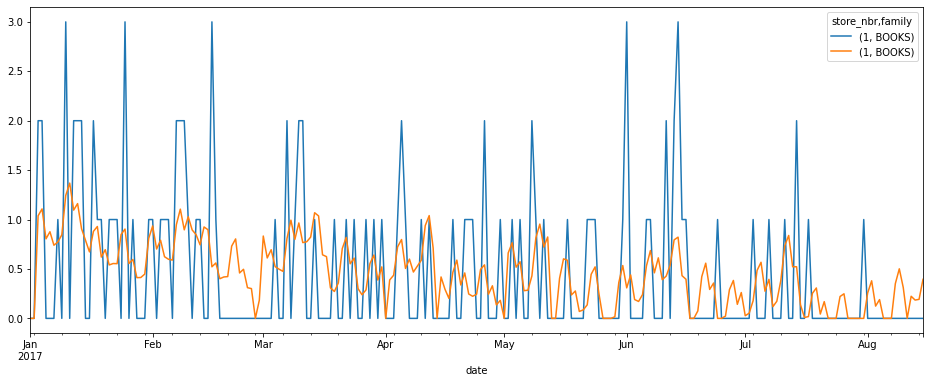

In [131]:
fig, ax = plt.subplots(figsize = (16, 6))
y_regression_.unstack(['store_nbr', 'family']).loc(axis = 1)[:, "1", "BOOKS"]["sales"].plot(ax = ax,
                                                                                                 label = "Ground Truth")
y_regression_.unstack(['store_nbr', 'family']).loc(axis = 1)[:, "1", "BOOKS"]["sales_pred"].plot(ax = ax,
                                                                                                 label = "Predictions")
plt.show()

In order to overcome that problem, two different models are used: a Random Forest Regressor for 'SCHOOL AND OFFICE SUPPLIES' and the already introduced Linear Regression for the remaining product families.

The procedure is inspired by the following notebook: https://www.kaggle.com/dkomyagin/simple-ts-ridge-rf

In [132]:
class CustomRegressor():
    
    def __init__(self, n_jobs = -1, verbose = 0):
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None
        
    def _estimator_(self, X, y):
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        
        # Select model depending on product family:
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            model = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 69)
        else:
            model = LinearRegression(fit_intercept = False)
        
        # Fit the model:
        model.fit(X, y)

        return model

    def fit(self, X, y):
        # https://stackoverflow.com/questions/42220458/what-does-the-delayed-function-do-when-used-with-joblib-in-python
        
        parallel_executor_fit = Parallel(n_jobs = self.n_jobs, verbose = self.verbose)
        tasks_fit = (delayed(self._estimator_)(X, y.iloc[:, col]) for col in range(y.shape[1]))
        
        self.estimators_ = parallel_executor_fit(tasks_fit)
        
        return
    
    def predict(self, X):
        parallel_executor_pred = Parallel(n_jobs = self.n_jobs, verbose = self.verbose)
        tasks_pred = (delayed(estimtr.predict)(X) for estimtr in self.estimators_)
        
        y_pred = parallel_executor_pred(tasks_pred)
        
        return np.stack(y_pred, axis = 1)

In [133]:
custom_model = CustomRegressor(n_jobs = -1, verbose = 0)

In [134]:
custom_model_fitted = custom_model.fit(X_regression_train, y_regression)

In [135]:
custom_model_pred = pd.DataFrame(custom_model.predict(X_regression_train), index = X_regression_train.index,
                                 columns = y_regression.columns)

Evaluate the custom model's predictions:

In [136]:
custom_model_pred_ = custom_model_pred.stack(['store_nbr', 'family']).copy()

In [137]:
y_regression_['sales_pred_custom'] = custom_model_pred_['sales'].clip(0.0)

In [138]:
y_regression_.groupby('family').\
    apply(lambda x: mean_squared_log_error(x['sales'],
                x['sales_pred_custom'])).sort_values(ascending = False)

family
LIQUOR,WINE,BEER              0.666202
LINGERIE                      0.380750
GROCERY II                    0.369782
GROCERY I                     0.319856
HOME AND KITCHEN I            0.319613
BEVERAGES                     0.301214
PRODUCE                       0.294090
CELEBRATION                   0.286852
LAWN AND GARDEN               0.274066
CLEANING                      0.274050
HARDWARE                      0.259508
BEAUTY                        0.254216
AUTOMOTIVE                    0.246395
SEAFOOD                       0.236767
MAGAZINES                     0.236706
LADIESWEAR                    0.230250
HOME AND KITCHEN II           0.226900
PLAYERS AND ELECTRONICS       0.217950
PET SUPPLIES                  0.204261
FROZEN FOODS                  0.197175
DAIRY                         0.193450
BREAD/BAKERY                  0.174811
EGGS                          0.162214
PERSONAL CARE                 0.158896
MEATS                         0.157741
POULTRY           

All MSLE are below 1.0 now!

### Predictions on test dataset:

In [139]:
X_test = det_process_regression.out_of_sample(steps = 16)
X_test.index.name = 'date'

In [140]:
X_test = X_test.join(holidays_2017_dummies, how = "left", on = "date").fillna(0.0)

In [141]:
X_test["new_year"] = (X_test.index.dayofyear == 1)
X_test["new_year"] = X_test.apply(lambda x: 1.0 if x["new_year"] == True else 0.0, axis = 1)

In [142]:
X_test = X_test.join(oildata["oil_price_interpolated"], how = "left", on = "date").fillna(0.0)

In [143]:
custom_model_pred_test = pd.DataFrame(custom_model.predict(X_test), index = X_test.index, columns = y_regression.columns)

### Create submission file:

In [144]:
submission = custom_model_pred_test.stack(['store_nbr', 'family'])

In [145]:
test_data = test_data.set_index(['store_nbr', 'family'], append = True).sort_index()

In [146]:
submission = submission.join(test_data.id).reindex(columns = ['id', 'sales'])

In [147]:
submission.to_csv('submission_10.csv', index = False)